In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import GridSearchCV
import matplotlib.dates as mdates
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import itertools
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Upload Kaggle API Key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedsayedjp","key":"09239f6bbcc96a5d4b5bdc1288f535ea"}'}

In [ ]:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download anirudhchauhan/retail-store-inventory-forecasting-dataset


Dataset URL: https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-dataset
License(s): CC0-1.0


In [ ]:
# Unzip Dataset
!unzip retail-store-inventory-forecasting-dataset.zip

Archive:  retail-store-inventory-forecasting-dataset.zip
  inflating: retail_store_inventory.csv  


In [ ]:
# Load Data
data_sales=pd.read_csv('/content/retail_store_inventory.csv')

In [ ]:
data_sales.head(10)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
5,2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter
6,2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring
8,2022-01-01,S001,P0009,Electronics,West,183,175,135,174.15,20.74,10,Cloudy,0,17.66,Autumn
9,2022-01-01,S001,P0010,Toys,South,108,28,196,24.47,59.99,0,Rainy,1,61.21,Winter


In [ ]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [ ]:
data_sales.shape

(73100, 15)

In [ ]:
# Convert Categorical Columns
data_sales[['Region','Category','Seasonality','Weather Condition']]=data_sales[['Region','Category','Seasonality','Weather Condition']].astype('category')

# **Cleaning and Preprocessing**

In [ ]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Date                73100 non-null  object  
 1   Store ID            73100 non-null  object  
 2   Product ID          73100 non-null  object  
 3   Category            73100 non-null  category
 4   Region              73100 non-null  category
 5   Inventory Level     73100 non-null  int64   
 6   Units Sold          73100 non-null  int64   
 7   Units Ordered       73100 non-null  int64   
 8   Demand Forecast     73100 non-null  float64 
 9   Price               73100 non-null  float64 
 10  Discount            73100 non-null  int64   
 11  Weather Condition   73100 non-null  category
 12  Holiday/Promotion   73100 non-null  int64   
 13  Competitor Pricing  73100 non-null  float64 
 14  Seasonality         73100 non-null  category
dtypes: category(4), float64(3), int64(5)

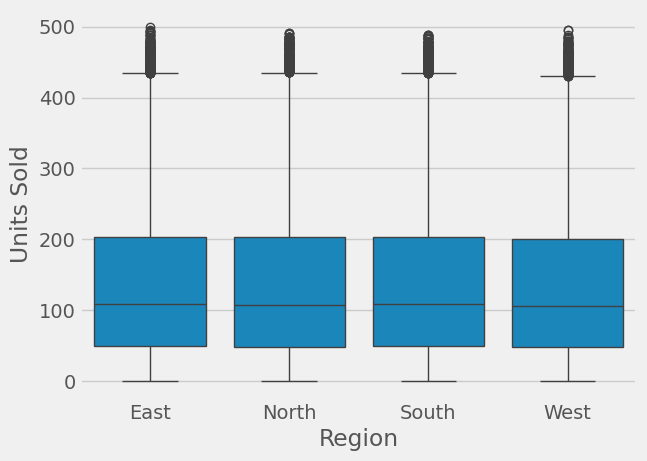

In [ ]:
# Boxplots the distribution of 'Units Sold' by Region
sns.boxplot(data=data_sales,x='Region',y='Units Sold')
plt.show()

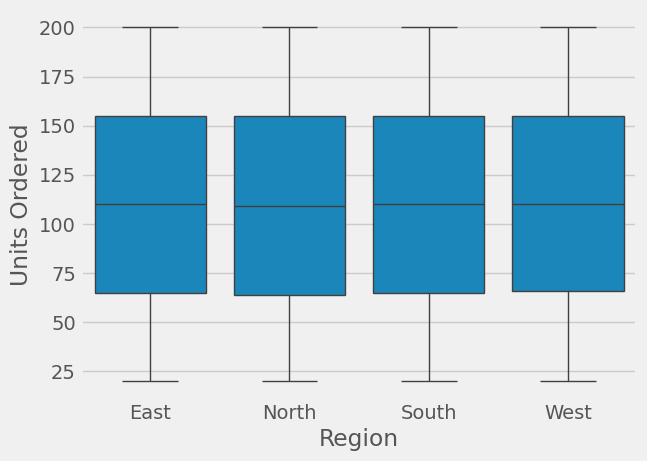

In [ ]:
# Boxplots the distribution of 'Units Ordered' by Region
sns.boxplot(data=data_sales,x='Region',y='Units Ordered')
plt.show()

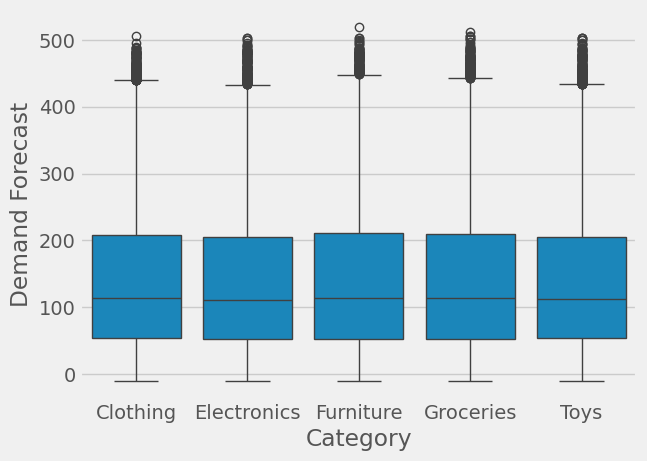

In [ ]:
sns.boxplot(data=data_sales,x='Category',y='Demand Forecast')
plt.show()

In [ ]:
# Check for Missing Values
data_sales.isnull().sum()

,0
Date,0
Store ID,0
Product ID,0
Category,0
Region,0
Inventory Level,0
Units Sold,0
Units Ordered,0
Demand Forecast,0
Price,0


In [ ]:
# Descriptive Statistics
data_sales.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


In [ ]:
# Correlation Analysis
corrlation=data_sales.copy()
corrlation.drop(columns=['Date','Store ID','Product ID'],inplace=True)

for col in ['Region','Category','Seasonality','Weather Condition']:
    corrlation[col]=corrlation[col].astype('category').cat.codes

corrlation.corr()

,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
Category,1.000000,0.000841,0.001439,0.000512,-0.001686,0.000495,0.001375,-0.001784,-0.000624,-0.000864,0.000947,-0.001474
Region,0.000841,1.000000,-0.006837,-0.003109,0.003172,-0.002467,-0.003576,-0.002696,0.000209,-0.001074,-0.003389,-0.000785
Inventory Level,0.001439,-0.006837,1.000000,0.589995,0.001060,0.588561,0.009140,0.004889,0.001898,0.003411,0.009365,-0.003425
Units Sold,0.000512,-0.003109,0.589995,1.000000,-0.000930,0.996853,0.001082,0.002576,0.004688,-0.000374,0.001259,-0.003324
Units Ordered,-0.001686,0.003172,0.001060,-0.000930,1.000000,-0.001102,0.004212,-0.000938,-0.001064,0.005446,0.004596,0.003492
Demand Forecast,0.000495,-0.002467,0.588561,0.996853,-0.001102,1.000000,0.000675,0.002338,0.004768,-0.000526,0.000844,-0.003109
Price,0.001375,-0.003576,0.009140,0.001082,0.004212,0.000675,1.000000,0.001509,-0.007715,0.002309,0.993900,0.005095
Discount,-0.001784,-0.002696,0.004889,0.002576,-0.000938,0.002338,0.001509,1.000000,-0.002302,-0.000852,0.001958,-0.004622
Weather Condition,-0.000624,0.000209,0.001898,0.004688,-0.001064,0.004768,-0.007715,-0.002302,1.000000,-0.002408,-0.007440,0.003646
Holiday/Promotion,-0.000864,-0.001074,0.003411,-0.000374,0.005446,-0.000526,0.002309,-0.000852,-0.002408,1.000000,0.001890,-0.001081


# **Visualistaion**

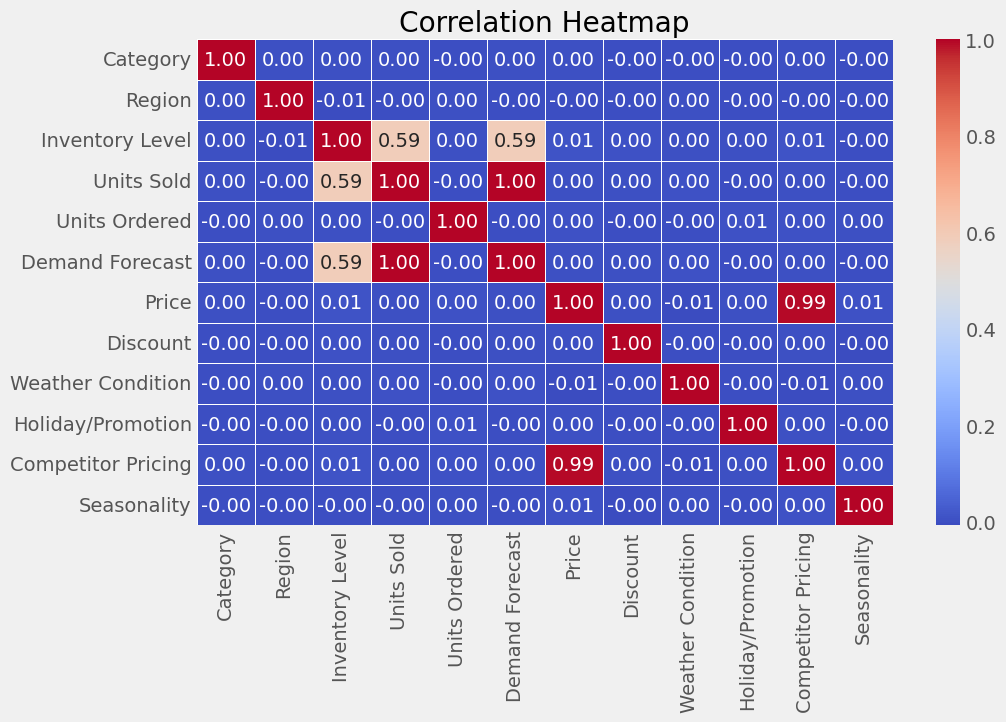

In [ ]:

plt.figure(figsize=(10, 6))
sns.heatmap(corrlation.corr(),annot=True,cmap='coolwarm',linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

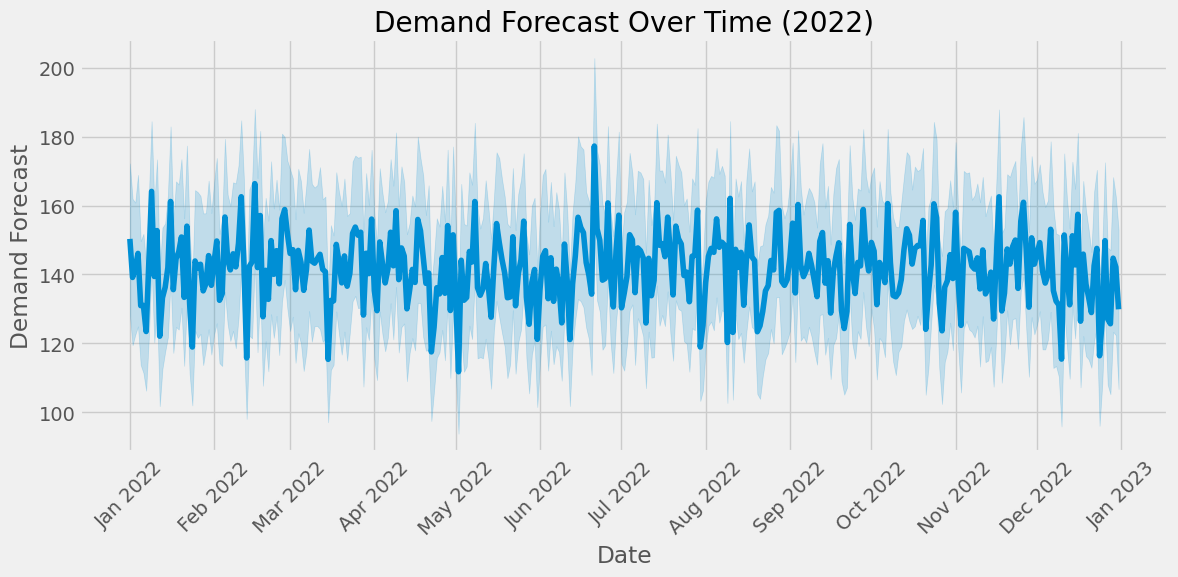

In [ ]:
# Convert 'Date' column to datetime format
data_sales['Date'] = pd.to_datetime(data_sales['Date'])

# Now filter the correct date range
filtered_data = data_sales[(data_sales['Date'] >= '2022-01-01') & (data_sales['Date'] <= '2022-12-31')]

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='Date', y='Demand Forecast')

plt.title('Demand Forecast Over Time (2022)')
plt.xlabel('Date')
plt.ylabel('Demand Forecast')

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2022"

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


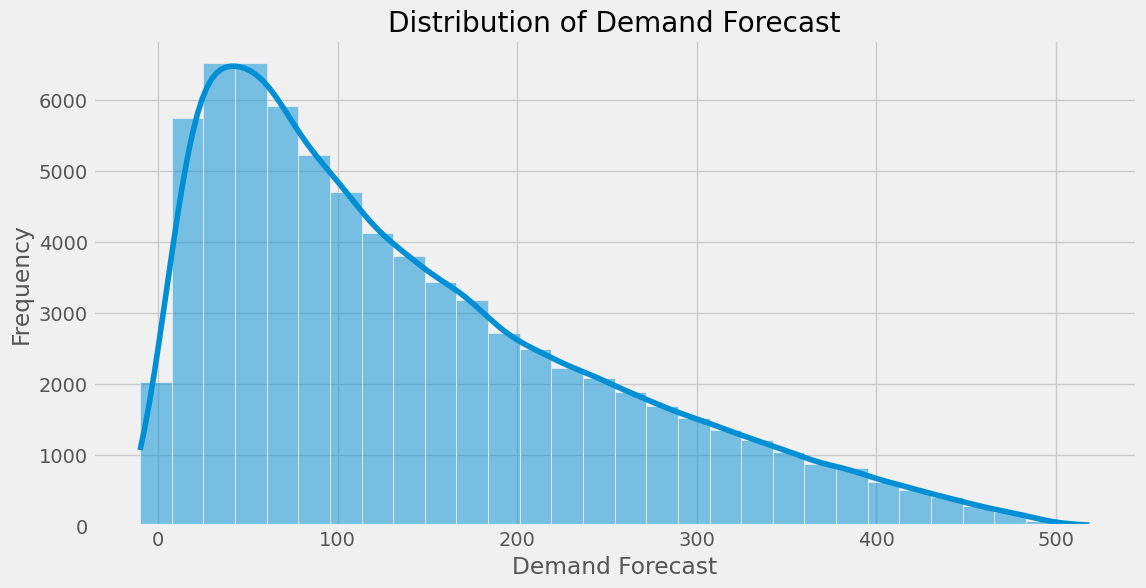

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data_sales, x='Demand Forecast', bins=30, kde=True)
plt.title('Distribution of Demand Forecast')
plt.xlabel('Demand Forecast')
plt.ylabel('Frequency')
plt.show()

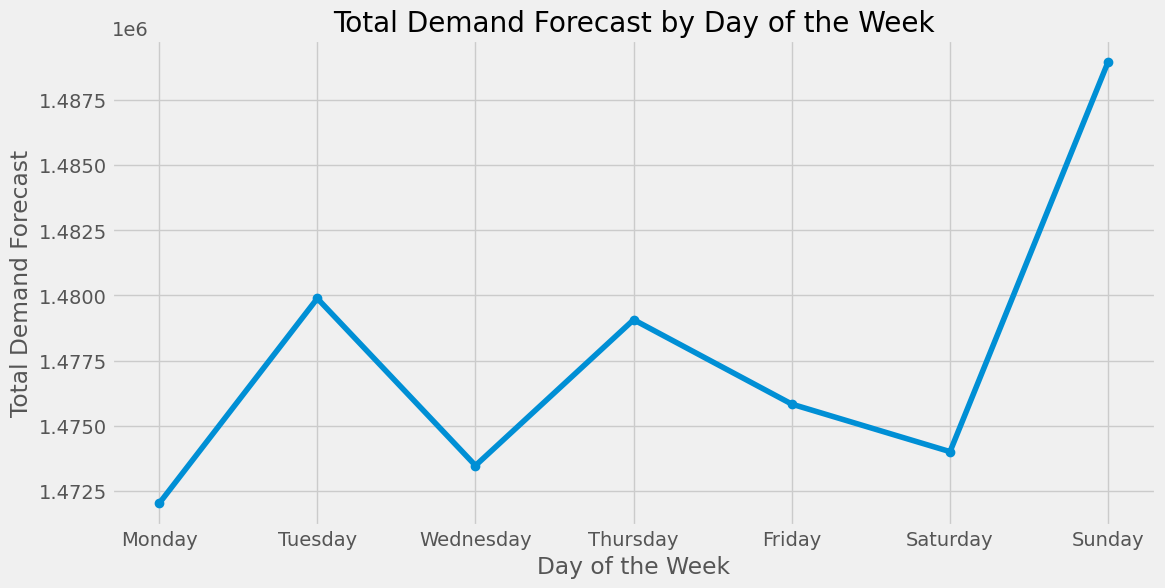

In [ ]:
# Extract day of the week from the Date column
data_sales['DayOfWeek'] = pd.to_datetime(data_sales['Date']).dt.day_name()

# Group by day of the week and sum the uDemand Forecast
daily_sales = data_sales.groupby('DayOfWeek')['Demand Forecast'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the data
plt.figure(figsize=(12, 6))
daily_sales.plot(kind='line', marker='o')
plt.title('Total Demand Forecast by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Demand Forecast')
plt.grid(True)
plt.show()

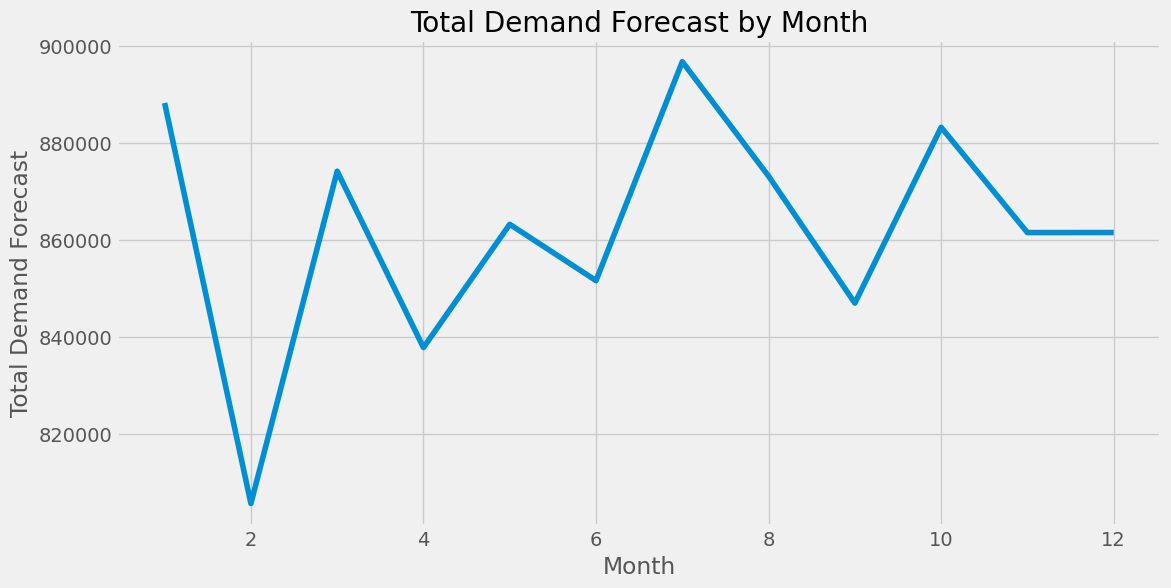

In [ ]:
data_sales['Month'] = pd.to_datetime(data_sales['Date']).dt.month
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_sales, x='Month', y='Demand Forecast', estimator=sum, ci=None)
plt.title('Total Demand Forecast by Month')
plt.xlabel('Month')
plt.ylabel('Total Demand Forecast')
plt.show()

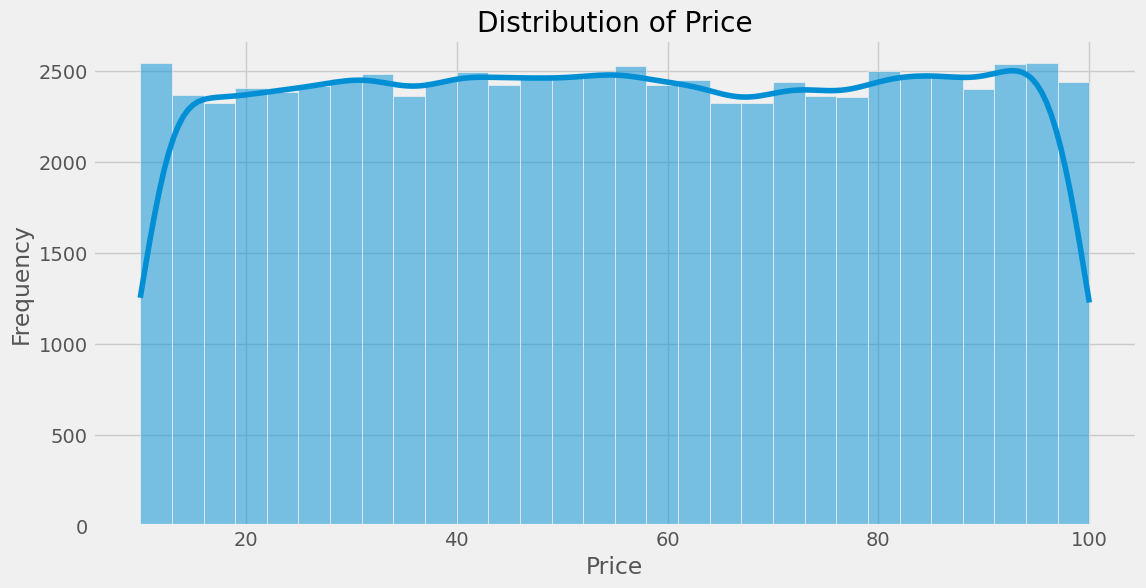

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data_sales, x='Price', bins=30, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

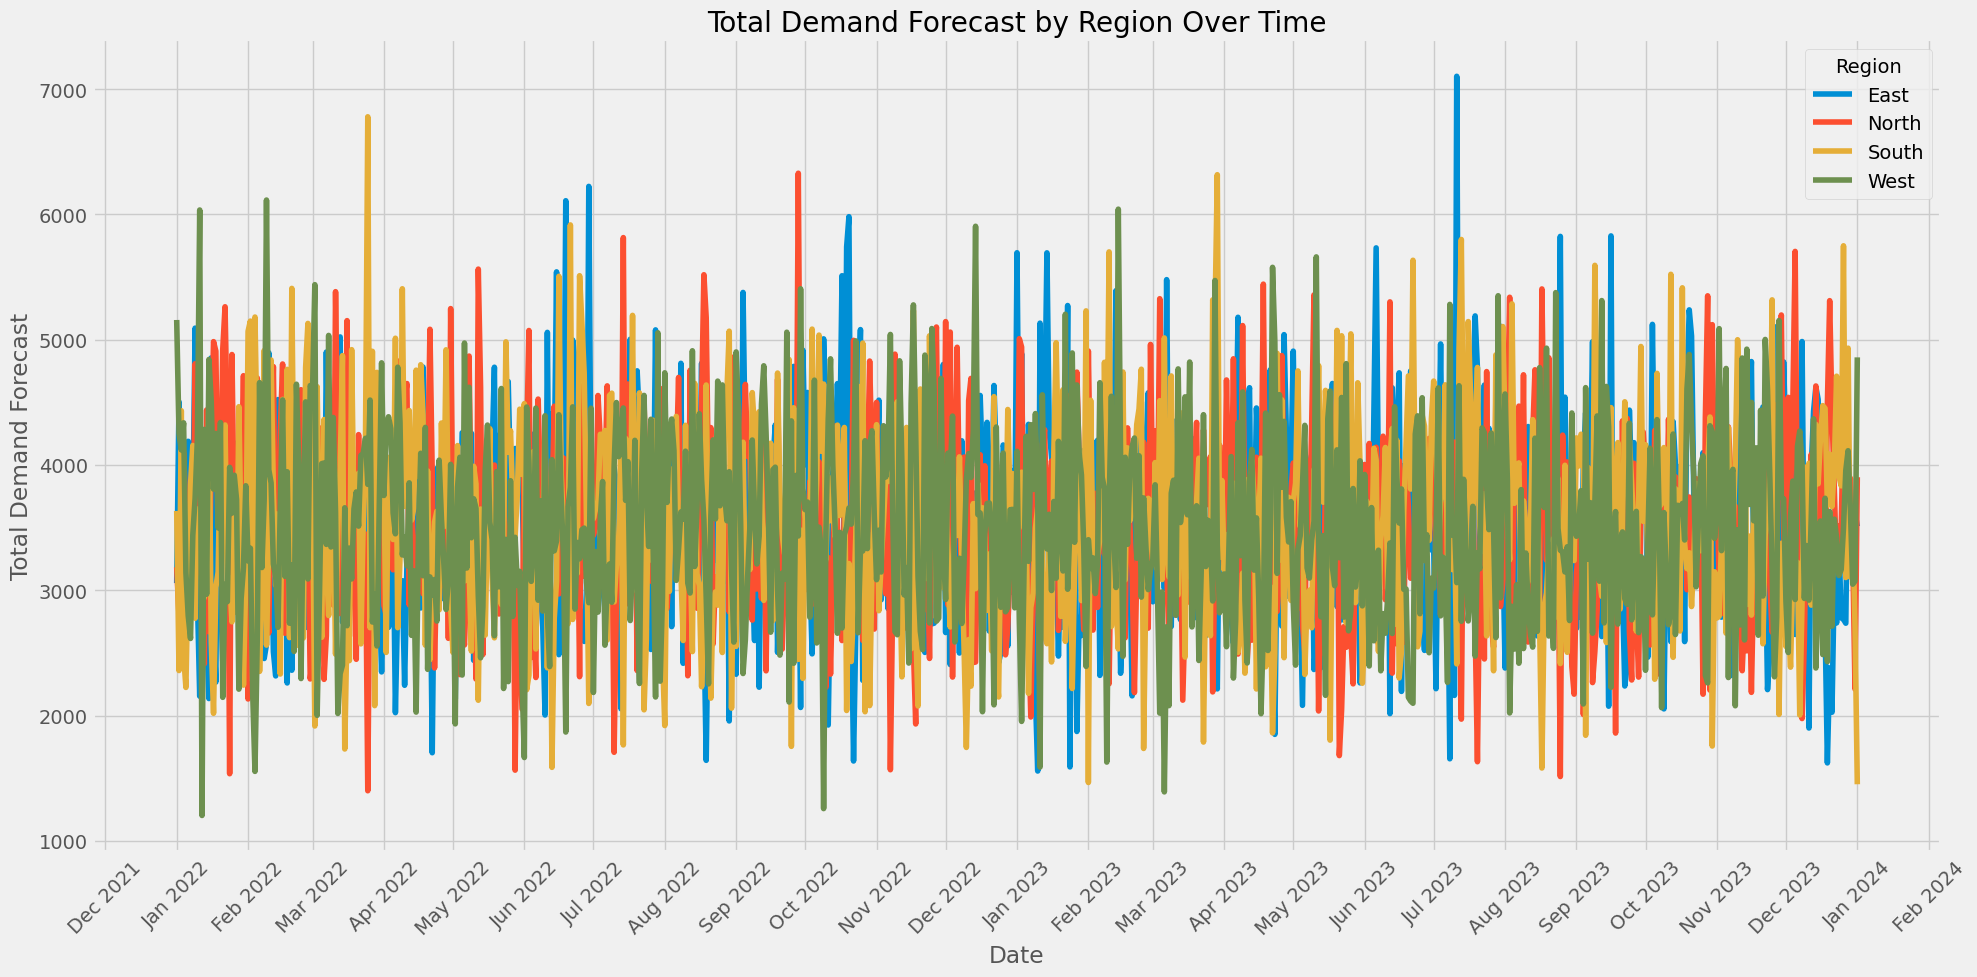

In [ ]:


plt.figure(figsize=(20, 10))
sns.lineplot(data=data_sales, x='Date', y='Demand Forecast', hue='Region', estimator=sum, ci=None)

plt.title('Total Demand Forecast by Region Over Time')
plt.xlabel('Date')
plt.ylabel('Total Demand Forecast')

# Fix the X-axis formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2022"

plt.xticks(rotation=45)  # Rotate labels for readability
plt.tight_layout()  # Adjust layout to prevent cutoff
plt.show()


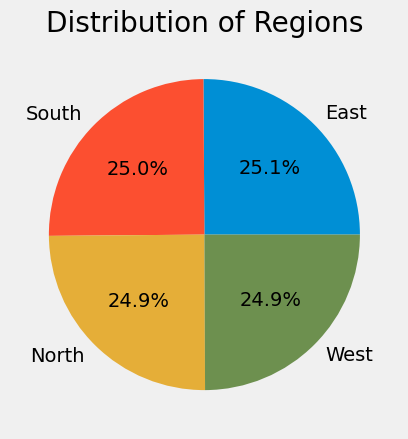

In [ ]:
plt.pie(data_sales['Region'].value_counts(), labels=data_sales['Region'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Regions')
plt.show()

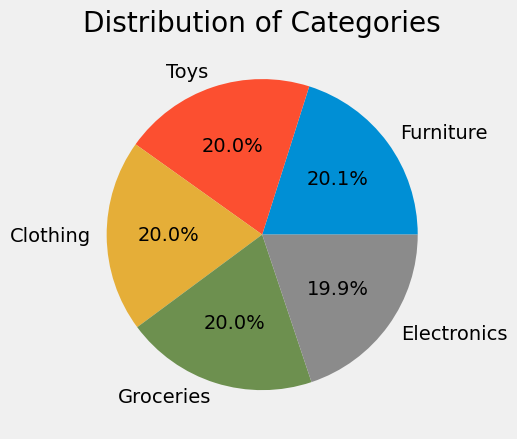

In [ ]:
plt.pie(data_sales['Category'].value_counts(), labels=data_sales['Category'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.show()

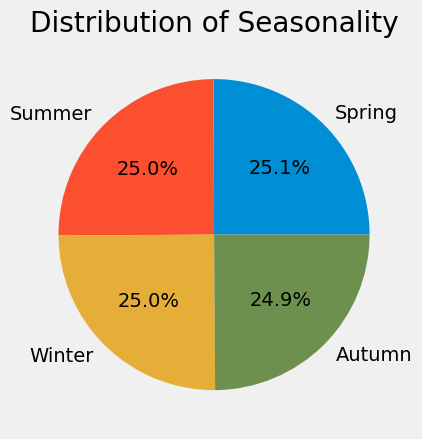

In [ ]:
plt.pie(data_sales['Seasonality'].value_counts(), labels=data_sales['Seasonality'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Seasonality')
plt.show()

# **Understanding Trends**

In [ ]:
grouped_data_weather = data_sales.groupby(['Category', 'Weather Condition'])['Demand Forecast'].sum().reset_index()

fig=px.bar(grouped_data_weather,x='Category',y='Demand Forecast',color='Weather Condition',color_discrete_map={  # Assign specific colors
        'Rainy': 'blue',
        'Sunny': 'orange',
        'Cloudy': 'grey',
        'Snowy': 'lightblue'
    })
fig.show()

In [ ]:
grouped_data_area = data_sales.groupby(['Date', 'Region'])['Demand Forecast'].sum().reset_index()
px.area(grouped_data_area,x='Date',y='Demand Forecast',color='Region')

In [ ]:
grouped_data_region = data_sales.groupby(['Category', 'Region'])['Demand Forecast'].sum().reset_index()
px.bar(grouped_data_region,x='Category',y='Demand Forecast',color='Region',barmode='group')

In [ ]:
grouped_data_seasonality = data_sales.groupby(['Category', 'Seasonality'])['Demand Forecast'].sum().reset_index()
px.bar(grouped_data_seasonality,x='Category',y='Demand Forecast',color='Seasonality',barmode='group')


In [ ]:
pip install prophet

# **Feature Engineering**

In [ ]:
data_sales['Date'].min(),data_sales['Date'].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2024-01-01 00:00:00'))

In [ ]:
# Step 1: Prepare Prophet Data
daily_df = data_sales.copy()
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

# Group by day: total demand per date
daily_df = daily_df.groupby('Date', as_index=False)['Units Sold'].sum()

# Add engineered features
daily_df['day_of_week'] = daily_df['Date'].dt.dayofweek
daily_df['month'] = daily_df['Date'].dt.month
daily_df['is_weekend'] = daily_df['day_of_week'].isin([5, 6]).astype(int)

# Rename for Prophet
daily_df = daily_df.rename(columns={'Date': 'ds', 'Units Sold': 'y'})

In [ ]:
daily_df.shape

(731, 5)

In [ ]:
# Step 2: spliting by date
split_date = '2023-10-01'
train_df = daily_df[daily_df['ds'] < split_date]
test_df = daily_df[daily_df['ds'] >= split_date]

In [ ]:
test_df.shape,train_df.shape

((93, 5), (638, 5))

# **Modeling and Trends**

Prophet

In [ ]:
# Step 3: Prophet Model with Regressors
m = Prophet()
m.add_regressor('day_of_week')
m.add_regressor('month')
m.add_regressor('is_weekend')

# Train the model
m.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])

# Step 4: Create future dataframe and forecast
future = m.make_future_dataframe(periods=len(test_df), freq='D')
future['day_of_week'] = future['ds'].dt.dayofweek
future['month'] = future['ds'].dt.month
future['is_weekend'] = future['day_of_week'].isin([5, 6]).astype(int)

forecast = m.predict(future)

# Step 5: Evaluation
forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaksacl41/fx27_usk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaksacl41/ix9ygwez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73415', 'data', 'file=/tmp/tmpaksacl41/fx27_usk.json', 'init=/tmp/tmpaksacl41/ix9ygwez.json', 'output', 'file=/tmp/tmpaksacl41/prophet_modeldqqvimft/prophet_model-20250512144202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 1027.57
MAE: 801.07
MAPE: 5.81%


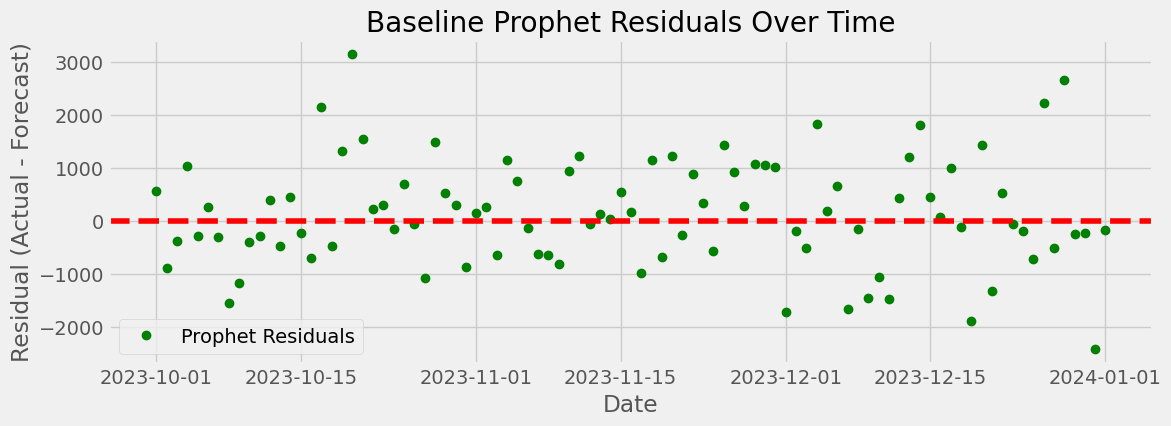

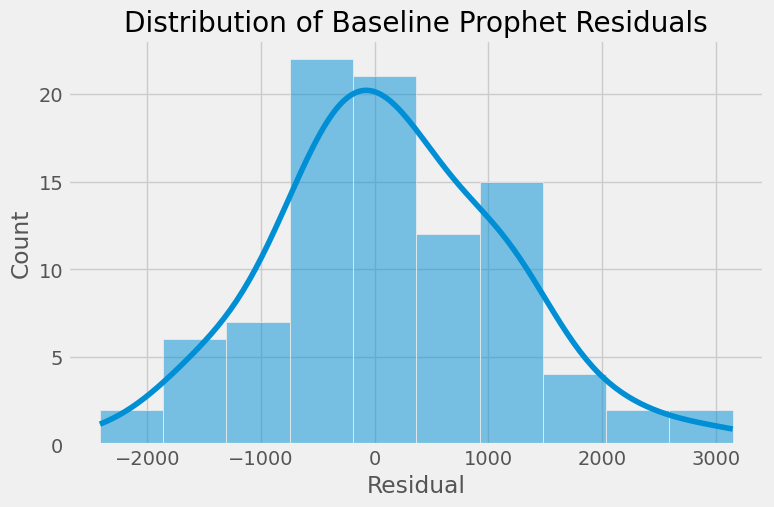

In [ ]:
residuals_prophet_baseline = y_true - y_pred
plt.figure(figsize=(12, 4))
plt.plot(test_df['ds'], residuals_prophet_baseline, label='Prophet Residuals', color='green', marker='o', linestyle='None')
plt.axhline(0, color='red', linestyle='--')
plt.title('Baseline Prophet Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(residuals_prophet_baseline, kde=True)
plt.title('Distribution of Baseline Prophet Residuals')
plt.xlabel('Residual')
plt.show()

LSTM

In [ ]:
train_data_lstm = train_df['y'].values
test_data_lstm = test_df['y'].values

# past 14 days to predict next day
SEQ_LEN = 14

def create_sequences(data, seq_length):
    """Creates sequences and labels for LSTM."""
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_train, y_train = create_sequences(train_data_lstm, SEQ_LEN)
X_test, y_test = create_sequences(test_data_lstm, SEQ_LEN)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build BASELINE LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(SEQ_LEN, 1)))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mse')

print("Training baseline LSTM...")
history_lstm_baseline = model_lstm.fit(X_train, y_train,
                                                epochs=30,
                                                batch_size=32,
                                                validation_data=(X_test, y_test),
                                                verbose=0)

# Predict on Test Set
y_pred_lstm = model_lstm.predict(X_test).flatten()

# Evaluate
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)

print("\n--- Baseline LSTM Model ---")
print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"LSTM MAPE: {mape_lstm:.2f}%")

Training baseline LSTM...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

--- Baseline LSTM Model ---
LSTM RMSE: 1180.13
LSTM MAE: 935.66
LSTM MAPE: 6.87%


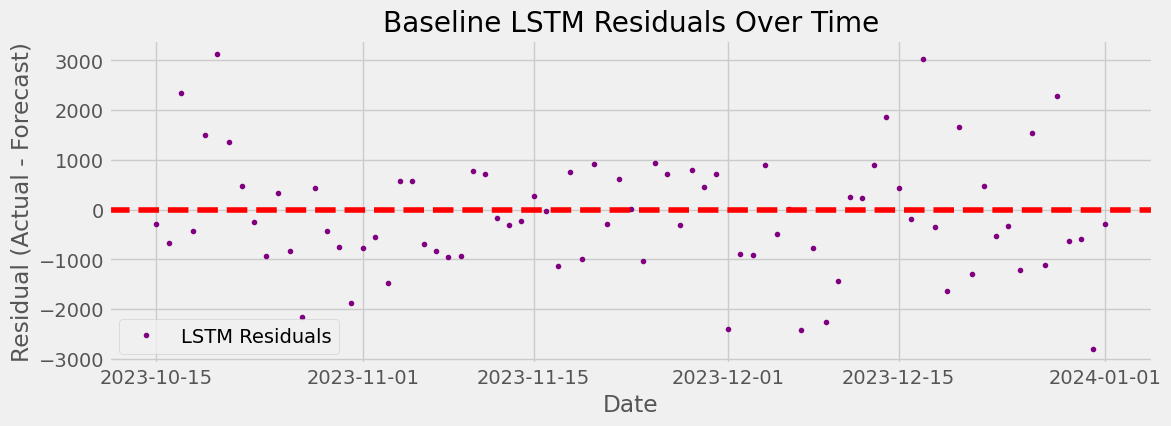

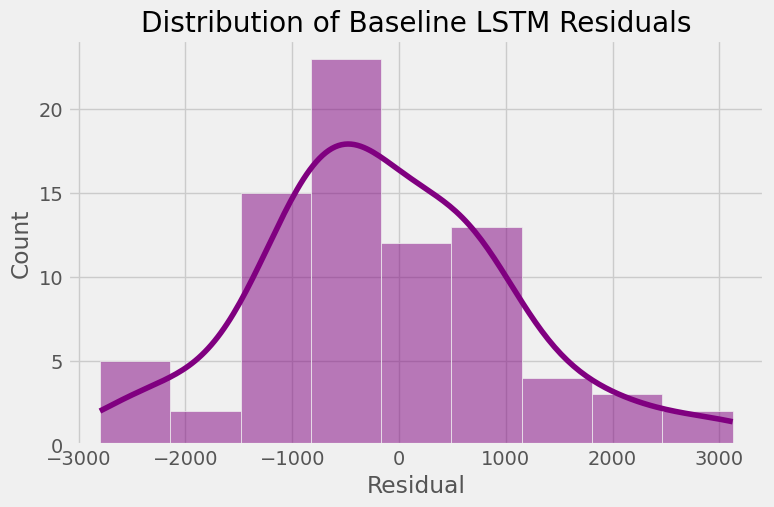

In [ ]:
test_dates_for_lstm_eval = test_df['ds'].iloc[SEQ_LEN:]

residuals_lstm = y_test - y_pred_lstm
plt.figure(figsize=(12, 4))
plt.plot(test_dates_for_lstm_eval, residuals_lstm, label='LSTM Residuals', color='purple', marker='.', linestyle='None')
plt.axhline(0, color='red', linestyle='--')
plt.title('Baseline LSTM Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(residuals_lstm, kde=True, color='purple')
plt.title('Distribution of Baseline LSTM Residuals')
plt.xlabel('Residual')
plt.show()

# **Train Models With Holidays**

Prophet

In [ ]:
cal = calendar()
holidays_list = cal.holidays(start=daily_df['ds'].min(),
                             end=daily_df['ds'].max(),
                             return_name=True)
holiday_df = pd.DataFrame(data=holidays_list, columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index': 'ds'})
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [ ]:
holiday_df.head()

,ds,holiday
0,2022-01-17,"Birthday of Martin Luther King, Jr."
1,2022-02-21,Washington's Birthday
2,2022-05-30,Memorial Day
3,2022-06-20,Juneteenth National Independence Day
4,2022-07-04,Independence Day


In [ ]:
m_hols = Prophet(holidays=holiday_df)

m_hols.add_regressor('day_of_week')
m_hols.add_regressor('month')
m_hols.add_regressor('is_weekend')

# Train the model using the training data
m_hols.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])

# Create future dataframe for prediction
future_hols = m_hols.make_future_dataframe(periods=len(test_df), freq='D')
# Add regressor values to the future dataframe
future_hols['day_of_week'] = future_hols['ds'].dt.dayofweek
future_hols['month'] = future_hols['ds'].dt.month
future_hols['is_weekend'] = future_hols['day_of_week'].isin([5, 6]).astype(int)

# Make predictions
forecast_hols = m_hols.predict(future_hols)

# Evaluate on the test set
forecast_test_hols = forecast_hols[forecast_hols['ds'].isin(test_df['ds'])]
y_true_hols = test_df['y'].values
y_pred_hols = forecast_test_hols['yhat'].values

# Calculate Metrics
rmse_hols = np.sqrt(mean_squared_error(y_true_hols, y_pred_hols))
mae_hols = mean_absolute_error(y_true_hols, y_pred_hols)
mape_hols = mean_absolute_percentage_error(y_true_hols, y_pred_hols)


print("\n--- Prophet Model with Holidays ---")
print(f"RMSE: {rmse_hols:.2f}")
print(f"MAE: {mae_hols:.2f}")
print(f"MAPE: {mape_hols:.2f}%")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaksacl41/nk52smft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaksacl41/pv0nhyb8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51795', 'data', 'file=/tmp/tmpaksacl41/nk52smft.json', 'init=/tmp/tmpaksacl41/pv0nhyb8.json', 'output', 'file=/tmp/tmpaksacl41/prophet_modelmwdfz1dr/prophet_model-20250512144817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:48:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:48:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Prophet Model with Holidays ---
RMSE: 1033.88
MAE: 810.45
MAPE: 5.89%


LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Create daily_df with the aggregated holiday/promotion flag
daily_df_features = data_sales.groupby('Date', as_index=False).agg(
    y=('Units Sold', 'sum'),
    holiday_promo_flag=('Holiday/Promotion', 'max')  # 1 if any promo on that day, else 0
)

# Convert 'Date' to datetime and add other time features
daily_df_features['ds'] = pd.to_datetime(daily_df_features['Date'])
daily_df_features['day_of_week'] = daily_df_features['ds'].dt.dayofweek
daily_df_features['month'] = daily_df_features['ds'].dt.month
daily_df_features['is_weekend'] = daily_df_features['day_of_week'].isin([5, 6]).astype(int)

# Ensure 'ds' is kept for splitting, then drop before scaling if not used as feature
daily_df_for_lstm = daily_df_features[['ds', 'y', 'day_of_week', 'month', 'is_weekend', 'holiday_promo_flag']].copy()

In [ ]:
# Features to use for LSTM input
# 'y' is the target, but also used as a feature (past sales)
lstm_feature_columns = ['y', 'day_of_week', 'month', 'is_weekend', 'holiday_promo_flag']
data_to_scale = daily_df_for_lstm[lstm_feature_columns].values

# Scale all selected features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_features.fit_transform(data_to_scale)

# We need a separate scaler for the 'y' column to inverse_transform predictions
scaler_y_only = MinMaxScaler(feature_range=(0, 1))
# Fit on the 'y' column (which is the first column of data_to_scale)
scaled_y_target = data_to_scale[:,0].reshape(-1, 1) # Reshape for scaler
scaler_y_only.fit(scaled_y_target)


# Split scaled data based on the original split_date
# Find the index corresponding to the split_date in daily_df_for_lstm
split_date_str = '2023-10-01' # Your split date
split_idx = daily_df_for_lstm[daily_df_for_lstm['ds'] >= pd.to_datetime(split_date_str)].index[0]

train_scaled_lstm = scaled_data[:split_idx]
test_scaled_lstm = scaled_data[split_idx:]

print(f"Shape of train_scaled_lstm: {train_scaled_lstm.shape}")
print(f"Shape of test_scaled_lstm: {test_scaled_lstm.shape}")

Shape of train_scaled_lstm: (638, 5)
Shape of test_scaled_lstm: (93, 5)


In [ ]:
SEQ_LEN = 14
N_FEATURES = len(lstm_feature_columns)

def create_sequences_multi(data, seq_length, n_features):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length), :]
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_train_lstm_hols, y_train_lstm_hols = create_sequences_multi(train_scaled_lstm, SEQ_LEN, N_FEATURES)
X_test_lstm_hols, y_test_lstm_hols = create_sequences_multi(test_scaled_lstm, SEQ_LEN, N_FEATURES)

print(f"X_train_lstm_hols shape: {X_train_lstm_hols.shape}")
print(f"y_train_lstm_hols shape: {y_train_lstm_hols.shape}")
print(f"X_test_lstm_hols shape: {X_test_lstm_hols.shape}")
print(f"y_test_lstm_hols shape: {y_test_lstm_hols.shape}")

X_train_lstm_hols shape: (624, 14, 5)
y_train_lstm_hols shape: (624,)
X_test_lstm_hols shape: (79, 14, 5)
y_test_lstm_hols shape: (79,)


In [ ]:
# Build LSTM Model
model_lstm_hols = Sequential()
model_lstm_hols.add(LSTM(64, activation='relu', input_shape=(SEQ_LEN, N_FEATURES))) # 64 units, same as baseline
model_lstm_hols.add(Dense(1)) # Output is a single value (the next 'y')

model_lstm_hols.compile(optimizer='adam', loss='mse')

print("\nTraining LSTM with holiday/promotion feature...")
history_lstm_hols = model_lstm_hols.fit(X_train_lstm_hols, y_train_lstm_hols,
                                          epochs=30,
                                          batch_size=32,
                                          validation_data=(X_test_lstm_hols, y_test_lstm_hols),
                                          verbose=0)
print("LSTM with holiday/promotion feature training complete.")

# Predict on Test Set (predictions are scaled)
y_pred_scaled_lstm_hols = model_lstm_hols.predict(X_test_lstm_hols)

# Inverse transform predictions to original 'y' scale
y_pred_lstm_hols_unscaled = scaler_y_only.inverse_transform(y_pred_scaled_lstm_hols).flatten()

# Get the corresponding TRUE 'y' values in original scale for evaluation
# y_test_lstm_hols are scaled. We need the original unscaled 'y' values.
# These correspond to the 'y' column starting from split_idx + SEQ_LEN
y_true_lstm_hols_unscaled = daily_df_for_lstm['y'].iloc[split_idx + SEQ_LEN:].values


# Evaluate using original scale values
rmse_lstm_hols = np.sqrt(mean_squared_error(y_true_lstm_hols_unscaled, y_pred_lstm_hols_unscaled))
mae_lstm_hols = mean_absolute_error(y_true_lstm_hols_unscaled, y_pred_lstm_hols_unscaled)
mape_lstm_hols = mean_absolute_percentage_error(y_true_lstm_hols_unscaled, y_pred_lstm_hols_unscaled)

print("\n--- LSTM Model with 'Holiday/Promotion' Feature (Baseline parameters) ---")
print(f"LSTM Holiday/Promo RMSE: {rmse_lstm_hols:.2f}")
print(f"LSTM Holiday/Promo MAE: {mae_lstm_hols:.2f}")
print(f"LSTM Holiday/Promo MAPE: {mape_lstm_hols:.2f}%")


Training LSTM with holiday/promotion feature...
LSTM with holiday/promotion feature training complete.


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

--- LSTM Model with 'Holiday/Promotion' Feature (Baseline parameters) ---
LSTM Holiday/Promo RMSE: 1077.49
LSTM Holiday/Promo MAE: 834.62
LSTM Holiday/Promo MAPE: 6.02%


# **Models With Hyperparameters**

Prophet

In [ ]:
import logging
prophet_logger = logging.getLogger("prophet")
prophet_logger.setLevel(logging.WARNING)
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.setLevel(logging.WARNING)

# Define the parameter grid
param_grid_prophet = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

best_rmse_prophet = float('inf')
best_mae_prophet = float('inf')
best_mape_prophet = float('inf')
best_params_prophet = {}

for params in ParameterGrid(param_grid_prophet):
    print(f"Testing Prophet with params: {params}")
    model_gs = Prophet(**params, holidays=holiday_df)
    model_gs.add_regressor('day_of_week')
    model_gs.add_regressor('month')
    model_gs.add_regressor('is_weekend')

    # Fit on training data
    model_gs.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])

    # Prepare future dataframe for prediction
    future_gs = model_gs.make_future_dataframe(periods=len(test_df), freq='D')
    future_gs['day_of_week'] = future_gs['ds'].dt.dayofweek
    future_gs['month'] = future_gs['ds'].dt.month
    future_gs['is_weekend'] = future_gs['day_of_week'].isin([5, 6]).astype(int)

    # Predict
    forecast_gs = model_gs.predict(future_gs)
    forecast_test_gs = forecast_gs[forecast_gs['ds'].isin(test_df['ds'])]
    y_pred_gs = forecast_test_gs['yhat'].values

    # Calculate metrics for current params
    current_rmse = np.sqrt(mean_squared_error(y_true, y_pred_gs))
    current_mae = mean_absolute_error(y_true, y_pred_gs)
    current_mape = mean_absolute_percentage_error(y_true, y_pred_gs)

    if current_rmse < best_rmse_prophet:
        best_rmse_prophet = current_rmse
        best_mae_prophet = current_mae
        best_mape_prophet = current_mape
        best_params_prophet = params
        print(f"    New best RMSE: {best_rmse_prophet:.2f} (MAE: {best_mae_prophet:.2f}, MAPE: {best_mape_prophet:.2f}%) with params: {best_params_prophet}")

print("\nProphet Hyperparameter Tuning Complete.")
print(f"Best hyperparameters: {best_params_prophet}")
print(f"Best RMSE from tuning: {best_rmse_prophet:.2f}")
print(f"Corresponding MAE: {best_mae_prophet:.2f}")
print(f"Corresponding MAPE: {best_mape_prophet:.2f}%")


# --- Question: Why is he training again with best hp after finding the best hp? ---
# Answer below. The refitting step is good practice.

# Refit with best params (Good Practice)
print("\nRefitting final Prophet model with best hyperparameters...")
final_best_prophet_model = Prophet(**best_params_prophet, holidays=holiday_df)
final_best_prophet_model.add_regressor('day_of_week')
final_best_prophet_model.add_regressor('month')
final_best_prophet_model.add_regressor('is_weekend')

# Fit the final model on the training data
final_best_prophet_model.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])

Testing Prophet with params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
    New best RMSE: 1059.31 (MAE: 813.00, MAPE: 5.84%) with params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
Testing Prophet with params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
Testing Prophet with params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}
Testing Prophet with params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}
Testing Prophet with params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}
    New best RMSE: 1059.29 (MAE: 813.31, MAPE: 5.84%) with params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}
Testing Prophet with params: {'changepo

Using best parameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
Fitting model on train_df...
Model fitting complete.

Generating predictions on the test set with the final model...
Prediction complete.

Calculating final performance metrics for the tuned model...

--- Final Tuned Prophet Model Performance ---
  RMSE: 1018.64
  MAE: 802.59
  MAPE: 5.87%
(These metrics should match the best found during tuning)


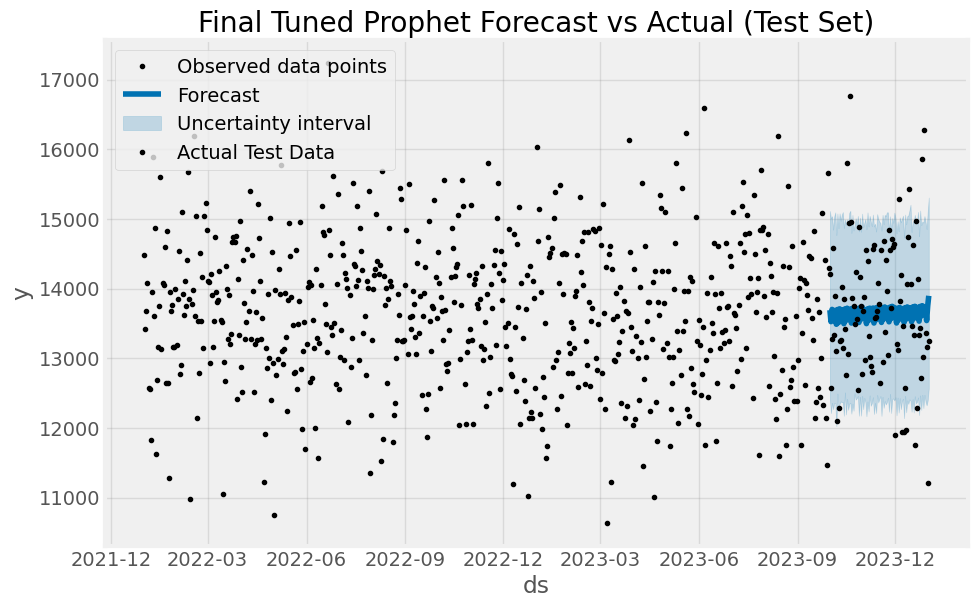

In [ ]:
print(f"Using best parameters: {best_params_prophet}")

final_best_prophet_model = Prophet(**best_params_prophet, holidays=holiday_df)
final_best_prophet_model.add_regressor('day_of_week')
final_best_prophet_model.add_regressor('month')
final_best_prophet_model.add_regressor('is_weekend')

# Fit the final model on the training data
print("Fitting model on train_df...")
final_best_prophet_model.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])
print("Model fitting complete.")

# --- Make predictions with the refitted model on the test set ---
print("\nGenerating predictions on the test set with the final model...")
future_final = final_best_prophet_model.make_future_dataframe(periods=len(test_df), freq='D')
future_final['day_of_week'] = future_final['ds'].dt.dayofweek
future_final['month'] = future_final['ds'].dt.month
future_final['is_weekend'] = future_final['day_of_week'].isin([5, 6]).astype(int)

forecast_final = final_best_prophet_model.predict(future_final)

# Filter forecast for the test period dates
forecast_test_final = forecast_final[forecast_final['ds'].isin(test_df['ds'])]
y_pred_final = forecast_test_final['yhat'].values

print("Prediction complete.")

# --- Calculate and display metrics for the refitted model ---
print("\nCalculating final performance metrics for the tuned model...")
rmse_final = np.sqrt(mean_squared_error(y_true, y_pred_final))
mae_final = mean_absolute_error(y_true, y_pred_final)
mape_final = mean_absolute_percentage_error(y_true, y_pred_final)

print("\n--- Final Tuned Prophet Model Performance ---")
print(f"  RMSE: {rmse_final:.2f}")
print(f"  MAE: {mae_final:.2f}")
print(f"  MAPE: {mape_final:.2f}%")
print("(These metrics should match the best found during tuning)")


fig_forecast_final = final_best_prophet_model.plot(forecast_test_final)
plt.plot(test_df['ds'], y_true, 'k.', label='Actual Test Data')
plt.title('Final Tuned Prophet Forecast vs Actual (Test Set)')
plt.legend()
plt.show()

LSTM

In [ ]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define parameter grid for LSTM
param_grid_lstm = {
    'units': [64, 128], # OLD_HP[64,128]
    'batch_size': [32], # OLD_HP[32,64]
    'epochs': [50], # OLD_HP[30,50]
    'learning_rate': [0.001, 0.0005],
    'dropout_rate': [0.0, 0.2],
    'num_layers': [2] # OLD_HP[1,2]
}

best_rmse_lstm_tuned = float('inf')
best_mae_lstm_tuned = float('inf')
best_mape_lstm_tuned = float('inf')
best_params_lstm_tuned = None
best_model_lstm_tuned = None

# Extract keys and values for itertools.product
keys, values = zip(*param_grid_lstm.items())

# Iterate over all combinations
for combo in itertools.product(*values):
    params = dict(zip(keys, combo))
    print(f"\nTesting LSTM with params: {params}")

    # Build LSTM model based on current params
    model_lstm_gs = Sequential()
    for i in range(params['num_layers']):
        return_sequences = (i < params['num_layers'] - 1)
        if i == 0:
            # First layer needs input_shape
            model_lstm_gs.add(LSTM(params['units'], activation='relu',
                                   return_sequences=return_sequences,
                                   input_shape=(SEQ_LEN, N_FEATURES)))
        else:
            model_lstm_gs.add(LSTM(params['units'], activation='relu',
                                   return_sequences=return_sequences))
        if params['dropout_rate'] > 0:
            model_lstm_gs.add(Dropout(params['dropout_rate']))
    model_lstm_gs.add(Dense(1))

    # Compile model
    optimizer = Adam(learning_rate=params['learning_rate'])
    model_lstm_gs.compile(optimizer=optimizer, loss='mse')

    # Train model (silently for tuning loop)
    history = model_lstm_gs.fit(X_train_lstm_hols, y_train_lstm_hols,
                                epochs=params['epochs'],
                                batch_size=params['batch_size'],
                                validation_data=(X_test_lstm_hols, y_test_lstm_hols),
                                verbose=0)

    # Predict on test set (scaled)
    y_pred_scaled_gs = model_lstm_gs.predict(X_test_lstm_hols)

    # Inverse transform predictions
    y_pred_unscaled_gs = scaler_y_only.inverse_transform(y_pred_scaled_gs).flatten()

    # Calculate metrics using unscaled values
    current_rmse = np.sqrt(mean_squared_error(y_true_lstm_hols_unscaled, y_pred_unscaled_gs))
    current_mae = mean_absolute_error(y_true_lstm_hols_unscaled, y_pred_unscaled_gs)
    current_mape = mean_absolute_percentage_error(y_true_lstm_hols_unscaled, y_pred_unscaled_gs)

    print(f"    RMSE: {current_rmse:.2f}, MAE: {current_mae:.2f}, MAPE: {current_mape:.2f}%")

    if current_rmse < best_rmse_lstm_tuned:
        best_rmse_lstm_tuned = current_rmse
        best_mae_lstm_tuned = current_mae
        best_mape_lstm_tuned = current_mape
        best_params_lstm_tuned = params
        best_model_lstm_tuned = model_lstm_gs
        print(f"    >>> New best LSTM model found!")

print("\nLSTM Hyperparameter Tuning Complete.")
print(f"Best LSTM hyperparameters found: {best_params_lstm_tuned}")
print(f"\nMetrics for the Best Tuned LSTM Model:")
print(f"  Best RMSE: {best_rmse_lstm_tuned:.2f}")
print(f"  Corresponding MAE: {best_mae_lstm_tuned:.2f}")
print(f"  Corresponding MAPE: {best_mape_lstm_tuned:.2f}%")


Testing LSTM with params: {'units': 64, 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.001, 'dropout_rate': 0.0, 'num_layers': 2}
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
    RMSE: 1054.37, MAE: 833.65, MAPE: 6.12%
    >>> New best LSTM model found!

Testing LSTM with params: {'units': 64, 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'num_layers': 2}
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
    RMSE: 1054.65, MAE: 824.83, MAPE: 5.99%

Testing LSTM with params: {'units': 64, 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.0005, 'dropout_rate': 0.0, 'num_layers': 2}
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
    RMSE: 1058.73, MAE: 824.68, MAPE: 5.98%

Testing LSTM with params: {'units': 64, 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.0005, 'dropout_rate': 0.2, 'num_layers': 2}
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step
    RMSE: 1094.59, MAE: 843.87, MAPE: 6.04%

Testing LSTM with params: {'units': 128, 'batch_size': 32, 'epochs': 50, 'learning_rate': 

Using best LSTM parameters found: {'units': 128, 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.001, 'dropout_rate': 0.0, 'num_layers': 2}
Best LSTM Metrics (from tuning loop): RMSE=1050.85, MAE=823.18, MAPE=5.98%

Generating predictions with the final best LSTM model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Verifying performance metrics for the best tuned LSTM model...
  Verified RMSE: 1050.85
  Verified MAE: 823.18
  Verified MAPE: 5.98%
(These should match the best metrics reported after the tuning loop)

Generating forecast vs actual plot for the final tuned LSTM model...


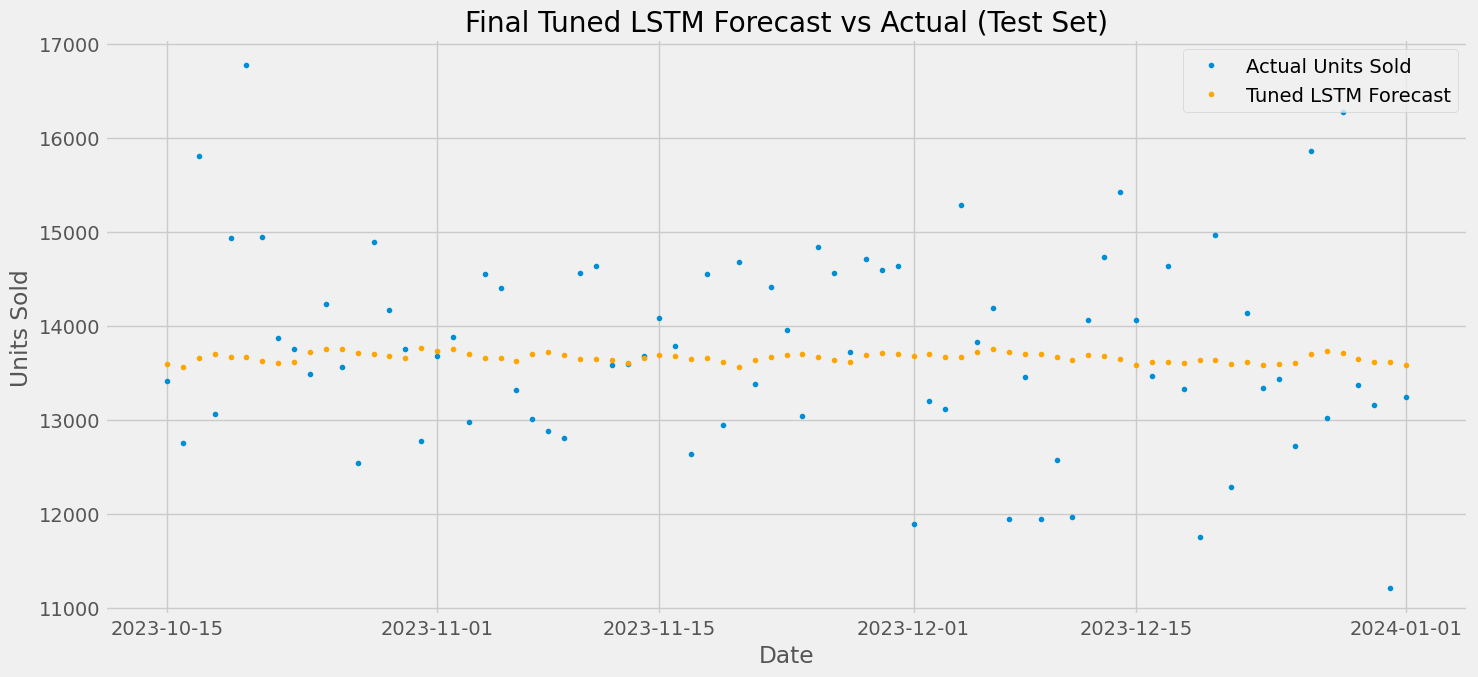

In [ ]:
print(f"Using best LSTM parameters found: {best_params_lstm_tuned}")
print(f"Best LSTM Metrics (from tuning loop): RMSE={best_rmse_lstm_tuned:.2f}, MAE={best_mae_lstm_tuned:.2f}, MAPE={best_mape_lstm_tuned:.2f}%")


print("\nGenerating predictions with the final best LSTM model...")
y_pred_scaled_best_lstm = best_model_lstm_tuned.predict(X_test_lstm_hols)

# Inverse transform predictions
y_pred_unscaled_best_lstm = scaler_y_only.inverse_transform(y_pred_scaled_best_lstm).flatten()

print("\nVerifying performance metrics for the best tuned LSTM model...")
rmse_best_lstm_check = np.sqrt(mean_squared_error(y_true_lstm_hols_unscaled, y_pred_unscaled_best_lstm))
mae_best_lstm_check = mean_absolute_error(y_true_lstm_hols_unscaled, y_pred_unscaled_best_lstm)
mape_best_lstm_check = mean_absolute_percentage_error(y_true_lstm_hols_unscaled, y_pred_unscaled_best_lstm)

print(f"  Verified RMSE: {rmse_best_lstm_check:.2f}")
print(f"  Verified MAE: {mae_best_lstm_check:.2f}")
print(f"  Verified MAPE: {mape_best_lstm_check:.2f}%")
print("(These should match the best metrics reported after the tuning loop)")

# --- Optional: Plot forecast vs actual for the final LSTM model ---
print("\nGenerating forecast vs actual plot for the final tuned LSTM model...")
# Get the dates corresponding to the predictions
test_dates_for_best_lstm_eval = daily_df_for_lstm['ds'].iloc[split_idx + SEQ_LEN:]

plt.figure(figsize=(15, 7))
plt.plot(test_dates_for_best_lstm_eval, y_true_lstm_hols_unscaled, marker='.', linestyle='None', label='Actual Units Sold')
plt.plot(test_dates_for_best_lstm_eval, y_pred_unscaled_best_lstm, marker='.', linestyle='None', color='orange', label='Tuned LSTM Forecast')
plt.title('Final Tuned LSTM Forecast vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print("Comparing Final Performance Metrics Across Models:\n")

# --- Prophet Models ---
print("--- Prophet ---")
try:
    print(f"  Baseline (Regressors):      RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%")
except NameError:
    print("  Baseline (Regressors):      Metrics not found (run the corresponding code).")

try:
    print(f"  Baseline (+ Holidays):      RMSE={rmse_hols:.2f}, MAE={mae_hols:.2f}, MAPE={mape_hols:.2f}%")
except NameError:
    print("  Baseline (+ Holidays):      Metrics not found (run the corresponding code).")

try:
    print(f"  Tuned (+ Holidays + HP):    RMSE={best_rmse_prophet:.2f}, MAE={best_mae_prophet:.2f}, MAPE={best_mape_prophet:.2f}%")
    print(f"    (Best Params: {best_params_prophet})")
except NameError:
    print("  Tuned (+ Holidays + HP):    Metrics not found (run the HP tuning loop).")


# --- LSTM Models ---
print("\n--- LSTM ---")
try:
    print(f"  Baseline (Univariate):      RMSE={rmse_lstm:.2f}, MAE={mae_lstm:.2f}, MAPE={mape_lstm:.2f}%")
except NameError:
    print("  Baseline (Univariate):      Metrics not found (run the corresponding code).")

try:
    print(f"  Baseline (Multi-Feature):   RMSE={rmse_lstm_hols:.2f}, MAE={mae_lstm_hols:.2f}, MAPE={mape_lstm_hols:.2f}%")
except NameError:
    print("  Baseline (Multi-Feature):   Metrics not found (run the corresponding code).")

try:
    print(f"  Tuned (Multi-Feature + HP): RMSE={best_rmse_lstm_tuned:.2f}, MAE={best_mae_lstm_tuned:.2f}, MAPE={best_mape_lstm_tuned:.2f}%")
    print(f"    (Best Params: {best_params_lstm_tuned})")
except NameError:
    print("  Tuned (Multi-Feature + HP): Metrics not found (run the HP tuning loop).")

print("\n============================================================")
print("(Lower RMSE, MAE, MAPE are better)")

Comparing Final Performance Metrics Across Models:

--- Prophet ---
  Baseline (Regressors):      RMSE=1041.00, MAE=801.07, MAPE=5.81%
  Baseline (+ Holidays):      RMSE=1033.88, MAE=810.45, MAPE=5.89%
  Tuned (+ Holidays + HP):    RMSE=1018.64, MAE=802.59, MAPE=5.87%
    (Best Params: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01})

--- LSTM ---
  Baseline (Univariate):      RMSE=1180.13, MAE=935.66, MAPE=6.87%
  Baseline (Multi-Feature):   RMSE=1077.49, MAE=834.62, MAPE=6.02%
  Tuned (Multi-Feature + HP): RMSE=1050.85, MAE=823.18, MAPE=5.98%
    (Best Params: {'units': 128, 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.001, 'dropout_rate': 0.0, 'num_layers': 2})

(Lower RMSE, MAE, MAPE are better)
